# SkikitLearn.jl

More info can be found in https://github.com/cstjean/ScikitLearn.jl

In [1]:
using RDatasets: dataset

iris = dataset("datasets", "iris")

# ScikitLearn.jl expects arrays, but DataFrames can also be used - see
# the corresponding section of the manual
X = convert(Array, iris[[:SepalLength, :SepalWidth, :PetalLength, :PetalWidth]])
y = convert(Array, iris[:Species]);

In [2]:
using ScikitLearn

INFO: Recompiling stale cache file /Users/ppalmes/.julia/lib/v0.5/ScikitLearn.ji for module ScikitLearn.


In [3]:
@sk_import linear_model: LogisticRegression

PyObject <class 'sklearn.linear_model.logistic.LogisticRegression'>

In [4]:
model=LogisticRegression()
fit!(model, X, y)

accuracy = sum(predict(model, X) .== y) / length(y)
println("accuracy: $accuracy")

accuracy: 0.96


In [5]:
@sk_import neighbors: KNeighborsClassifier


using ScikitLearn.CrossValidation: cross_val_score
modelKNN = KNeighborsClassifier(3)
cross_val_score(modelKNN, X, y; cv=10)  # 5-fold

10-element Array{Float64,1}:
 1.0     
 0.933333
 1.0     
 0.933333
 0.866667
 1.0     
 0.933333
 1.0     
 1.0     
 1.0     

In [6]:
using ScikitLearn.GridSearch: GridSearchCV

In [7]:
gridsearch = GridSearchCV(LogisticRegression(), Dict(:C => 0.1:0.1:2.0))
fit!(gridsearch, X, y)
println("Best parameters: $(gridsearch.best_params_)")

Best parameters: Dict{Symbol,Any}(Pair{Symbol,Any}(:C,1.1))


In [25]:
using Plots
gr()
plot([scores.parameters[:C] for scores in gridsearch.grid_scores_],
    [scores.mean_validation_score for scores in gridsearch.grid_scores_],
    xlabel="C",ylabel="cross-validation scores")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.5 
 
 
 1.0 
 
 
 1.5 
 
 
 2.0 
 
 
 0.85 
 
 
 0.90 
 
 
 0.95 
 
 
 C 
 
 
 cross-validation scores 
 
 
 
 
 
 
 y1

In [24]:
gridsearch.grid_scores_[1].mean_validation_score

0.8133333333333334

In [26]:
using ScikitLearn: fit!, predict

In [27]:
using ScikitLearn.CrossValidation: train_test_split
using DecisionTree
#using ScikitLearn.Models: DecisionTreeClassifier, RandomForestClassifier, AdaBoostStumpClassifier
@sk_import preprocessing: StandardScaler
@sk_import datasets: (make_moons, make_circles, make_classification)
@sk_import neighbors: KNeighborsClassifier
@sk_import svm: SVC
@sk_import naive_bayes: GaussianNB
@sk_import discriminant_analysis: (LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis)
using ScikitLearn.Utils: meshgrid

In [28]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree (Julia)",
         "Random Forest (Julia)", "AdaBoost (Julia)", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(pruning_purity_threshold=0.8),
    RandomForestClassifier(ntrees=20),
    # Note: scikit-learn's adaboostclassifier is better than DecisionTree.jl in this instance
    # because it's not restricted to stumps, and the data isn't axis-aligned
    AdaBoostStumpClassifier(niterations=30),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()
];

In [29]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
srand(42)
X += 2 * rand(size(X)...)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ];


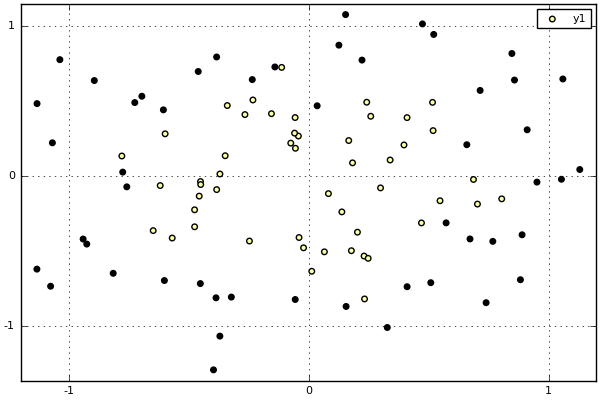

In [30]:
X,y=datasets[2]; pyplot();a=Plots.scatter(X[:,1],X[:,2],c=y)

In [31]:
using PyCall
using PyPlot
@pyimport matplotlib.colors as mplc

In [36]:
fig = figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets
    # preprocess dataset, split into training and test part
    X, y = ds
    X = fit_transform!(StandardScaler(), X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = minimum(X[:, 1]) - .5, maximum(X[:, 1]) + .5
    y_min, y_max = minimum(X[:, 2]) - .5, maximum(X[:, 2]) + .5
    xx, yy = meshgrid(x_min:h:x_max, y_min:h:y_max)

    # just plot the dataset first
    cm = PyPlot.cm[:RdBu]
    cm_bright = mplc.ListedColormap(["#FF0000", "#0000FF"])
    ax = subplot(length(datasets), length(classifiers) + 1, i)
    # Plot the training points
    ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
    # and testing points
    ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, alpha=0.6)

    ax[:set_xlim](minimum(xx), maximum(xx))
    ax[:set_ylim](minimum(yy), maximum(yy))
    ax[:set_xticks](())
    ax[:set_yticks](())
    i += 1

    # iterate over classifiers
    for (name, clf) in zip(names, classifiers)
        ax = subplot(length(datasets), length(classifiers) + 1, i)
        fit!(clf, X_train, y_train)
        scor = score(clf, X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        try 
            # Not implemented for some
            Z = decision_function(clf, hcat(xx[:], yy[:]))
        catch
            Z = predict_proba(clf, hcat(xx[:], yy[:]))[:, 2]
        end

        # Put the result into a color plot
        Z = reshape(Z, size(xx)...)
        ax[:contourf](xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
        # and testing points
        ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax[:set_xlim](minimum(xx), maximum(xx))
        ax[:set_ylim](minimum(yy), maximum(yy))
        ax[:set_xticks](())
        ax[:set_yticks](())
        ax[:set_title](name)

        ax[:text](maximum(xx) - .3, minimum(yy) + .3, @sprintf("%.2f", scor),
                size=15, horizontalalignment="right")
        i += 1
    end
end
fig[:subplots_adjust](left=.02, right=.98)

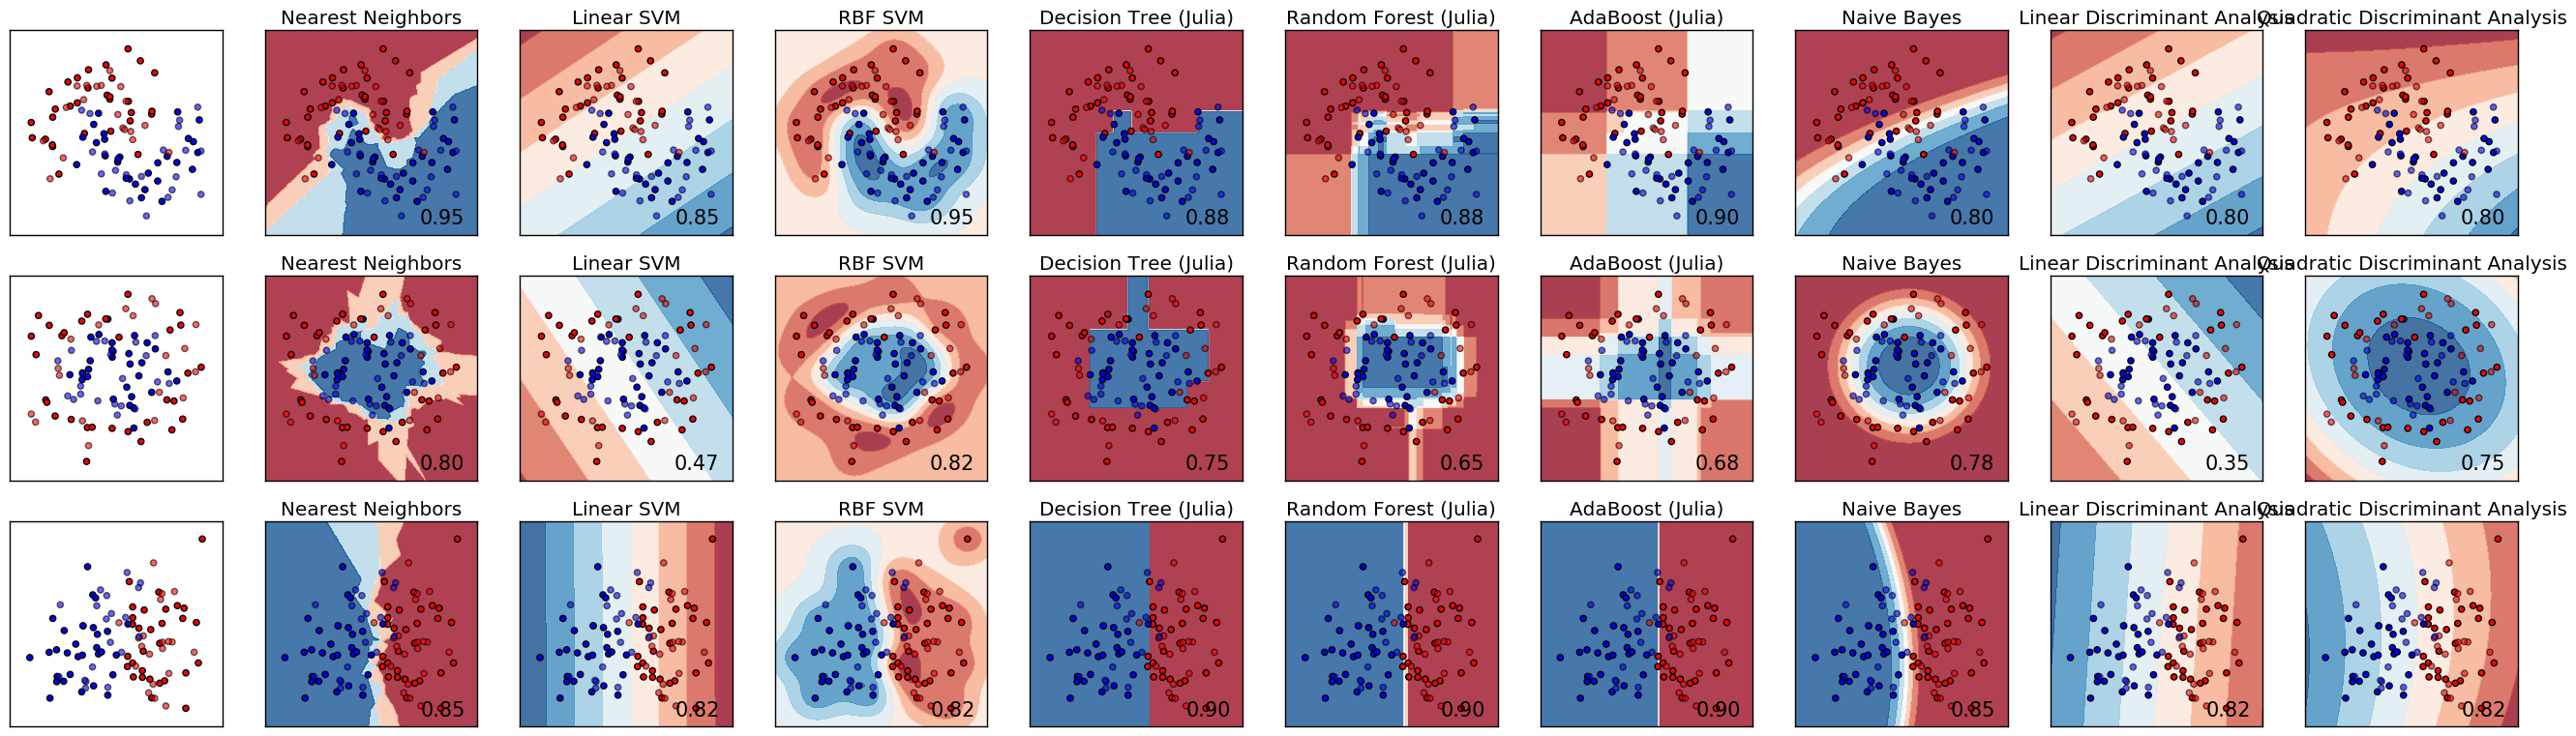

In [37]:
fig